In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [24]:
df = pd.read_csv(r"C:\Users\maill\Documents\GitHub\SARA\data\fusion3.csv", low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date'], axis=1)
df['place'] = df['place'].astype('object')
df = df.dropna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2291739 entries, 0 to 2291796
Data columns (total 35 columns):
 #   Column              Dtype  
---  ------              -----  
 0   place               object 
 1   catu                object 
 2   grav                object 
 3   sexe                object 
 4   trajet              object 
 5   locp                object 
 6   actp                object 
 7   etatp               object 
 8   secuUn              object 
 9   tranches_ages       object 
 10  catr                object 
 11  circ                object 
 12  nbv                 float64
 13  vosp                object 
 14  prof                object 
 15  plan                object 
 16  surf                object 
 17  infra               object 
 18  situ                object 
 19  obs                 object 
 20  obsm                object 
 21  choc                object 
 22  manv                object 
 23  catv_Label          object 
 24  lum                 obje

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Séparation de la variable cible y avant l'encodage
y = df['grav']

X = df.drop('grav', axis=1)


In [28]:
# Création de l'ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Frequency encoding
categorical_columns = X_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    freq_map = X_train[col].value_counts(normalize=True).to_dict()
    X_train[col] = X_train[col].map(freq_map)
    X_test[col] = X_test[col].map(freq_map)
    # gérer les éventuelles valeurs manquantes qui pourraient apparaitre dans X_test
    X_test[col].fillna(0, inplace=True)


In [30]:
#Utilisation des poids de classe pour l'entrainement du modèle RandomForest
# Calculer la fréquence des classes
class_counts = y_train.value_counts()
class_freq = class_counts / len(y_train)

# Inverser la fréquence pour obtenir les poids
class_weights = 1 / class_freq

# Créer un dictionnaire des poids
weights_dict = class_weights.to_dict()
print(weights_dict)

{'Indemne': 2.44364813639926, 'Blessé léger': 2.776838562713179, 'Blessé hospitalisé': 4.903570310974648, 'Tué': 37.42378036333945}


In [31]:
# Entrainement du modèle
from time import time

t0 = time()
model = RandomForestClassifier(class_weight=weights_dict, random_state=42, max_depth=25, min_samples_split= 5, n_jobs= -1)

model.fit(X_train, y_train)
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

Réalisé en 219.703 secondes


In [32]:
model.score(X_train, y_train)

0.857323942355995

In [33]:
model.score(X_test, y_test)

0.6577862235681186

In [34]:
# Evaluation du modèle
t0 = time()
y_pred = model.predict(X_test)
t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))


Réalisé en 6.956 secondes
Classe prédite      Blessé hospitalisé  Blessé léger  Indemne   Tué
Classe réelle                                                      
Blessé hospitalisé               49120         25970    12640  5914
Blessé léger                     28836         95425    38928  1853
Indemne                          11939         19724   154056  1756
Tué                               6737          1468     1088  2894
                    precision    recall  f1-score   support

Blessé hospitalisé       0.51      0.52      0.52     93644
      Blessé léger       0.67      0.58      0.62    165042
           Indemne       0.75      0.82      0.78    187475
               Tué       0.23      0.24      0.24     12187

          accuracy                           0.66    458348
         macro avg       0.54      0.54      0.54    458348
      weighted avg       0.66      0.66      0.65    458348



In [35]:
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f'F1-Score micro: {f1_micro}')

F1-Score micro: 0.6577862235681186


In [36]:
from imblearn.metrics import geometric_mean_score

geometric_mean_score(y_test, y_pred)


0.4932257772332798

In [37]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.5404834057368725

In [9]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from time import time

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {'n_estimators': [110,120,130],
              'min_samples_split':[2,5,10],
              'min_samples_leaf':[1,5,10],
             }

classif = RandomForestClassifier(class_weight=weights_dict, random_state=42)

grid_search = GridSearchCV(classif, param_grid, cv=cv, scoring='roc_auc_ovo', verbose=2)

t0 = time()

grid_search.fit(X_train, y_train)

t1 = time() - t0
print("Réalisé en {} secondes".format(round(t1,3)))

print("les meilleurs parametres sont:", grid_search.best_params_)
print("meilleur score ROC_AUC:", grid_search.best_score_)
print('score sur les données de test:', grid_search.score(X_test, y_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=22.1min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=21.5min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=23.6min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=22.6min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=110; total time=24.0min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=27.1min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=25.0min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=23.8min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=25.6min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=120; total time=23.7min
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=130; 

[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=110; total time=11.8min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=120; total time=12.8min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=120; total time=12.7min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=120; total time=12.7min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=120; total time=12.7min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=120; total time=12.7min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=130; total time=13.8min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=130; total time=13.7min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=130; total time=13.9min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=130; total time=13.9min
[CV] END min_samples_leaf=10, min_samples_split=2, n_estimators=130; total time=14.0min
[CV] END min_samples_leaf=10, mi

In [10]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))

Classe prédite      Blessé hospitalisé  Blessé léger  Indemne    Tué
Classe réelle                                                       
Blessé hospitalisé               49397         21184    11118  11945
Blessé léger                     36278         87443    37000   4321
Indemne                          14486         19835   149838   3316
Tué                               5267           952      884   5084
                    precision    recall  f1-score   support

Blessé hospitalisé       0.47      0.53      0.50     93644
      Blessé léger       0.68      0.53      0.59    165042
           Indemne       0.75      0.80      0.78    187475
               Tué       0.21      0.42      0.28     12187

          accuracy                           0.64    458348
         macro avg       0.53      0.57      0.54    458348
      weighted avg       0.65      0.64      0.64    458348



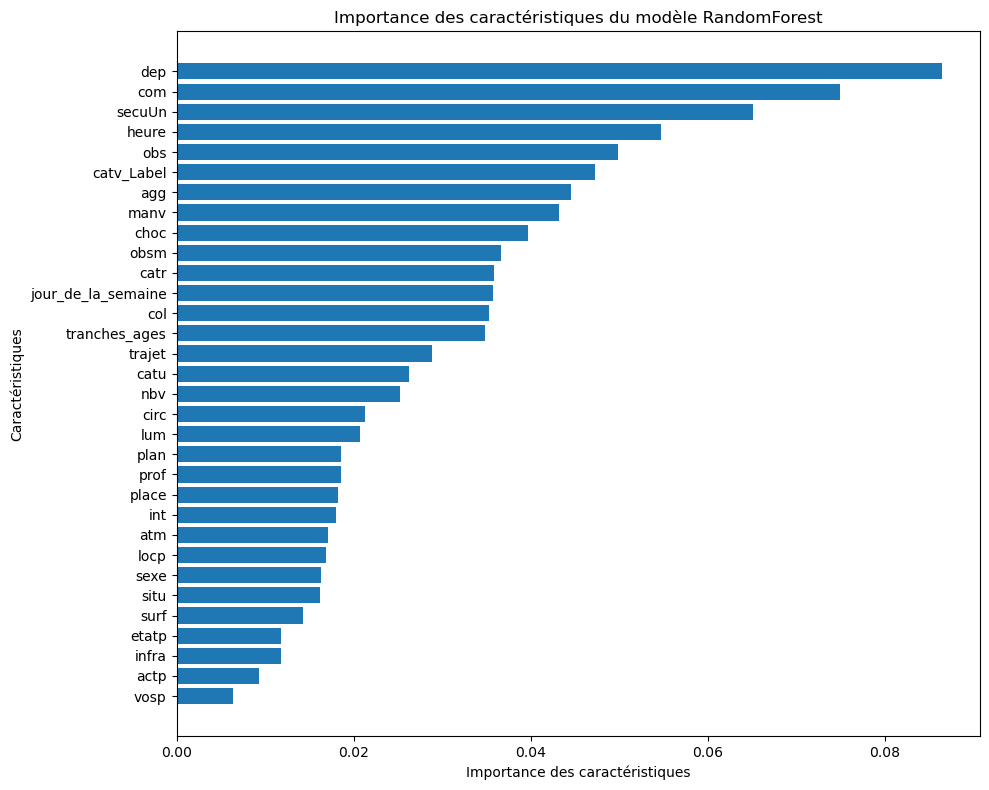

In [31]:
# Obtenir les importances des caractéristiques et les noms des caractéristiques
feature_importances = model.feature_importances_
feature_names = list(X.columns)

# Obtenir les indices triés des importances des caractéristiques
sorted_indices = feature_importances.argsort()

# Tracer les importances des caractéristiques dans l'ordre décroissant
plt.figure(figsize=(10,8))
plt.title('Importance des caractéristiques du modèle RandomForest')
plt.barh([feature_names[i] for i in sorted_indices], feature_importances[sorted_indices])
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.tight_layout()
plt.show()


C:\Users\maill\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


(-0.8, 0.8)

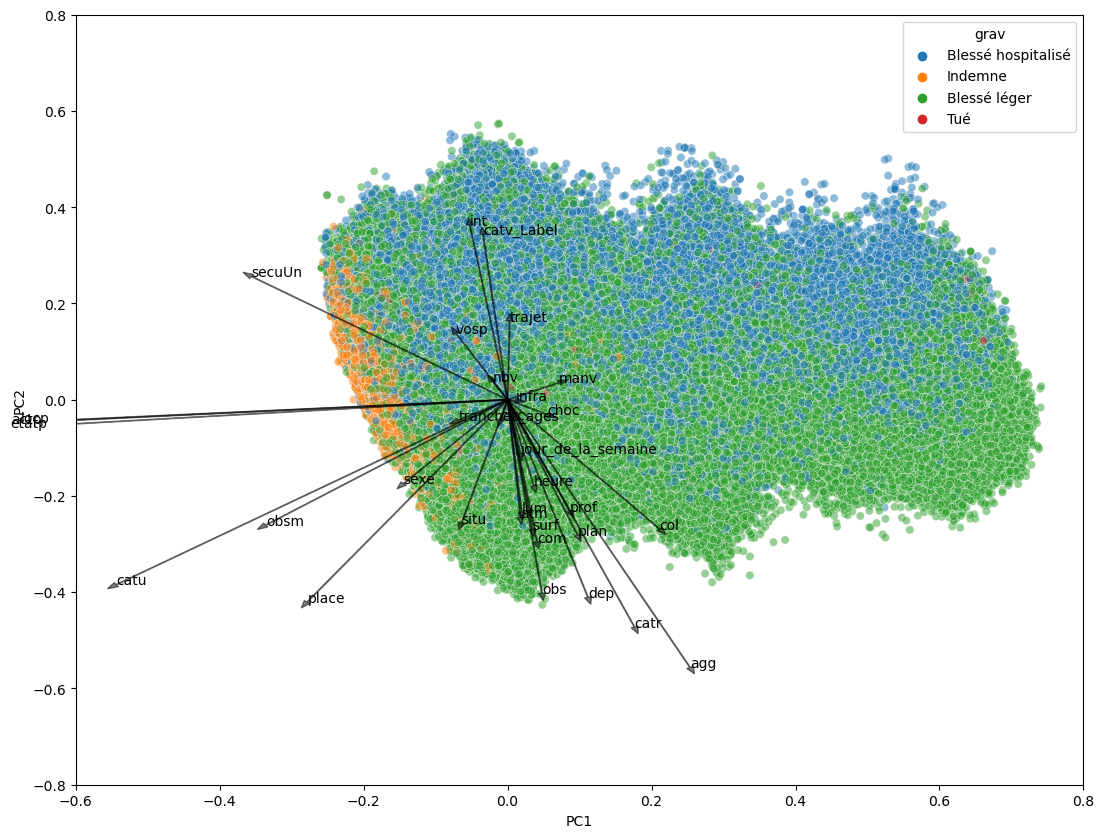

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n = X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_new = pca.fit_transform(X_train_scaled)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = model.predict(X_train_scaled)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='grav')], axis=1)


plt.figure(figsize=(13, 10))

sns.scatterplot(x='PC1', y='PC2', hue='grav', data=finalDF, alpha=0.5)

for i in range(n):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.5, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, X_train.columns[i], color='k')

plt.xlim(-0.6, 0.8)
plt.ylim(-0.8, 0.8)